# TILs-project
This notebook is a copy of `4. Investestigating Survival/Recurrance` with changes as to match the endpoints studied by Felicia Leion.

In [1]:
import pandas as pd
from itertools import combinations
import regex as re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
matplotlib.rcParams['font.family'] = "sans"


In [2]:
df_pat = pd.read_excel('../data/tnbc2/256_TNBC__F_LEION_till_arvid.xlsx')

df_pat["nodes"] = df_pat["Positive nodes"]
df_pat["age"] = df_pat["Age at diagnosis"]
df_pat["size"] = df_pat["Size (mm)"]

df_pat = df_pat.replace(-0.99, np.NaN)
df_pat = df_pat.replace("N/D", np.NaN)
df_pat = df_pat.replace("x", np.NaN)
#df_pat = df_pat[~df_pat["TILs helsnitt"].isna()]

df_pat["treated"] = df_pat["Chemo (schema)"].apply(lambda x: x != "None")
df_pat["relapse"] = df_pat["Relapse yes 1 no 0"].astype(np.bool)
df_pat["dead"] = df_pat["Dead yes 1 no 0"].astype(np.bool)

df_pat["distant_relapse"] = (df_pat["Months_surgery_distant_relapse"] > 0)

df_pat["OS"] = ~df_pat["dead"] # Overall Survival
df_pat["IDFS"] = ~df_pat["relapse"] # Invasive Disease Free Survival (not relapse)
df_pat["DRFI"] = ~df_pat["distant_relapse"] # Distant Relapse Free Survival (not distant relapse)

df_pat = df_pat[df_pat["treated"]]

In [3]:
df_pat["IDFS"].value_counts()

True     124
False     31
Name: IDFS, dtype: int64

In [4]:

def pat_id_wsi(image_id):
    try:
        return int(re.findall(r"\d+", image_id)[0])
    except:
        return np.NaN

def pat_id_tma(image_name):
    block,  nr, letter = re.findall(r"Block_(\d).*_(.*)_([A-Z])_", image_name)[0]
    block_start = [1, 59, 113, 172, 210]
    start = block_start[int(block)-1]
    
    letter = letter.lower()
    key = np.array([i for i in range(start, start + int(10*12/2)) for n in range(2)]).reshape((10,12))
    pat_id = key[int(nr)-1][11 - (ord(letter) - 97)]
    return pat_id
    
def _tma_id(patient_id):
    block_start = [1, 59, 113, 172, 210]
    start = [s for s in block_start if patient_id >= s][-1]
    block = block_start.index(start) + 1
            
    key = np.array([i for i in range(start, start + int(10*12/2)) for n in range(2)]).reshape((10,12))
    Y, X = np.where(key == patient_id) 
    letters = [chr(11 - (x - 97)).upper() for x in X]
    numbers = list(Y + 1)
    return block, letters, numbers
    

In [5]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    pass
    #print(df_wsi.sort_values("TMAid"))
    #print(df_wsi["TMAid"].value_counts())

In [6]:
from joblib import Memory

memory = Memory('./cache/')

def extract_features(path):
    df = pd.read_feather(path)
    return df

def merge_patient_data_wsi(df_wsi, df_pat):
    df_pat["STR"] = df_pat["TILs helsnitt"]
    df_wsi["TMAid"] = df_wsi["image_id"].apply(pat_id_wsi)
    df_mean = df_wsi.groupby("TMAid").mean().reset_index()
    df_all = pd.merge(df_pat, df_mean, how='left', on=["TMAid"])
    return df_all.sort_values("TMAid")

def merge_patient_data_tma(df_tma, df_pat):
    df_pat["STR"] = df_pat["TILs TMA"]
    df_tma["TMAid"] = df_tma["image_id"].apply(pat_id_tma)
    df_mean = df_tma.groupby("TMAid").mean().reset_index()
    df_all = pd.merge(df_pat, df_mean, how='left', on=["TMAid"])
    return df_all.sort_values("TMAid")


In [7]:
IMAGE_TYPE = "TMA"
df_treated = pd.read_pickle(f"./df_treated_{IMAGE_TYPE}.pickle")

In [8]:
def tma_df():
    df_tma = extract_features('./tma_quip2_0.2_5_1.0.feather')
    df_all = merge_patient_data_tma(df_tma, df_pat)
    return df_all

def wsi_df():
    df_wsi = extract_features('./wsi_quip2_0.2_5_1.0_800.feather')
    df_all = merge_patient_data_wsi(df_wsi, df_pat)
    return df_all

In [9]:
# Agrees with Felicias report
df = tma_df()
print(df["OS"].value_counts())
print(df["IDFS"].value_counts())
print(df["DRFI"].value_counts())
print()

df = wsi_df()
print(df["OS"].value_counts())
print(df["IDFS"].value_counts())
print(df["DRFI"].value_counts())

True     126
False     29
Name: OS, dtype: int64
True     124
False     31
Name: IDFS, dtype: int64
True     134
False     21
Name: DRFI, dtype: int64

True     126
False     29
Name: OS, dtype: int64
True     124
False     31
Name: IDFS, dtype: int64
True     134
False     21
Name: DRFI, dtype: int64


In [10]:
df[["OS", "STR"]]

,OS,STR
0,True,0.35
1,True,0.40
2,True,0.40
3,True,0.10
4,True,0.70
...,...,...
150,True,0.70
151,True,0.70
152,True,0.60
153,True,0.10


In [11]:
import statsmodels.api as sm
from numpy import mean
from numpy import std
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

from numpy.linalg import LinAlgError
from statsmodels.tools.sm_exceptions import PerfectSeparationError
from sklearn.neural_network import MLPClassifier


def _results_to_pandas(summary):
    return pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

def logit(x_train, y_train, x_val, y_val):
    try:
        model = sm.Logit(y_train, x_train).fit(disp=False)
        return model.predict(x_val), model
    except (LinAlgError, PerfectSeparationError):
        return np.random.rand(*y_val.shape), None

def cross_validation(y, X, model = logit):
    if len(y.shape) > 1:
        y = y.iloc[:,0]

    X = (X-X.mean())/X.std()
    X = pd.DataFrame(X)
    X["Intercept"] = 1.0
    
    true, pred, = ([], [])
    summaries = []
    
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    for train_val_idx, test_idx in cv_outer.split(X, y):
        X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
        y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]

        cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        for train_idx, val_idx in cv_inner.split(X_train_val, y_train_val):
            x_train, x_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
            y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

            #x_train, y_train = pipeline.fit_resample(x_train, y_train)
            
            y_pred, m = model(x_train, y_train, x_val, y_val)
            true.extend(list(y_val))
            pred.extend(list(y_pred))
            if m:
                summaries.append(_results_to_pandas(m.summary()))
                
    if summaries:
        result = sum(summaries) / len(summaries)
    else:
        result = None
        
    return true, pred, result

def cross_validation_test(y, X, model = logit):
    if len(y.shape) > 1:
        y = y.iloc[:,0]

    X = (X-X.mean())/X.std()
    X["Intercept"] = 1.0
    
    true, pred, = ([], [])
    summaries = []
    
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    for train_val_idx, test_idx in cv_outer.split(X, y):
        X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
        y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]

        y_pred, m = model(X_train_val, y_train_val, X_test, y_test)
        true.extend(list(y_test))
        pred.extend(list(y_pred))
        if m:
            summaries.append(_results_to_pandas(m.summary()))
                
    if summaries:
        result = sum(summaries) / len(summaries)
    else:
        result = None
        
    return true, pred, result

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
def plot_roc(df, endpoint, feature, label, ax):
    df = df[[endpoint, feature]].dropna()
    n = len(df)
    true, pred, summary = cross_validation(df[endpoint], df[feature])
    auc = round(roc_auc_score(true, pred), 2)
    fpr, tpr, _ = roc_curve(true, pred)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc}, n={n})", linewidth=4)
    plt.legend()

/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


<Figure size 864x288 with 0 Axes>

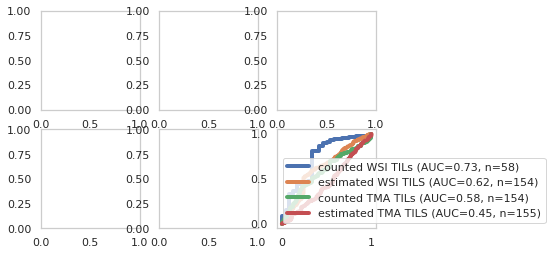

In [13]:
plt.figure(figsize=(12,4))
fig, axs = plt.subplots(nrows=2, ncols=3)
wsi = wsi_df()
ax = axs[0,0]
ax = plot_roc(wsi, "OS", "n_immune", "counted WSI TILs", axs)
ax = plot_roc(wsi, "OS", "STR", "estimated WSI TILS", ax)

ax = axs[0,1]
tma = tma_df()
ax = plot_roc(tma, "OS", "n_immune", "counted TMA TILs", ax)
ax = plot_roc(tma, "OS", "STR", "estimated TMA TILS", ax)

In [14]:
from itertools import combinations, chain, product, permutations
from tqdm import tqdm
from patsy import dmatrices, dmatrix
from scipy.stats import pearsonr
group = ["distant_relapse"]

image_features = set([
    "STR",
    "n_immune",
    "n_tumor",
    "tumor_area",
    "immune_area",
    'tumor_k_100',
    'immune_k_100',
    "t_tils_100",
    "s_tils_100",
])

pat_features = set(['age', 'nodes', "size"])
all_features = image_features.union(pat_features)

def label(feature):
    r = re.findall("\d{1,3}", feature)
    if feature == "n_immune":
        return "$N_i$"
    elif feature == "n_tumor":
        return "$N_t$"
    elif feature == "immune_area":
        return "$A_i$"
    elif feature == "tumor_area":
        return "$A_t$"
    elif feature.startswith("s_tils"):
        return "$N_{is}(" + r[0] + ")$"
    elif feature.startswith("t_tils"):
        return "$N_{it}(" + r[0] + ")$"
    elif feature.startswith("immune_k"):
        return "$K_{i}(" + r[0] + ")$"
    elif feature.startswith("tumor_k"):
        return "$K_{t}(" + r[0] + ")$"
    elif feature == "nodes":
        return "$N_n$"
    elif feature == "STR":
        return feature
    else:
        return feature.title()

pd.options.mode.chained_assignment = None

def try_interactions(data, features, target, n_features = [1], test=False):
    d = []
    for f in tqdm(list(chain(*[combinations(features, i) for i in n_features]))):
        f = list(f)
        nona = data[f + [target]].dropna()
        y = nona[target]
        X = nona[f]
        if test:
            true, pred, results = cross_validation_test(y, X, logit)
        else:
            true, pred, results = cross_validation(y, X, logit)
            
        auc = roc_auc_score(true, pred)
        fpr, tpr, thresholds = roc_curve(true, pred)
        d.append({
            "formula" : f,
            "AUC" : auc,
            "tpr" : tpr,
            "fpr" : fpr,
            "thresh" : thresholds,
            "model" : results,
            "target" : target
        })
            
    return pd.DataFrame(d).sort_values("AUC", ascending=False).reset_index()

def best_features(df,features, target, n=10):
    result = []
    for f in features:
        y, X = dmatrices(f"{target} ~ {f}", df, NA_action='drop', return_type='dataframe')
        true, pred, _ = cross_validation(y, X, logit)
        auc = roc_auc_score(true, pred)
        result.append((f, auc))
        
    return [f[0] for f in sorted(result, key = lambda x: x[1], reverse=True)[:n]]

def filter_correlated(df, corr_limit = 0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_limit)]
    return df.drop(to_drop, axis=1)

def high_correlation(df, corr_limit):
    return [(a,b) for a, b in combinations(df.columns, 2)
            if df[[a,b]].corr().iloc[0,1] > corr_limit]

def worse_predictor(df, feature_pairs, target):
    f = []
    for a, b in feature_pairs:
        f.append(min(a,b, key = lambda x: auc_formula(df, f"{target} ~ {x}")))
    return set(f)

def auc_formula(data, formula, test=False):
    y, X = dmatrices(formula, data, NA_action='drop', return_type='dataframe')
    if test:
        true, pred, m = cross_validation_test(y, X, logit)
    else:
        true, pred, m = cross_validation(y, X, logit)
    auc = roc_auc_score(true, pred)
    fpr, tpr, _ = roc_curve(true, pred)
    return fpr, tpr, auc, m


In [15]:
# All single image features
test = True
n_features = [1]
feat = image_features
#df_treated = df_all[df_all["treated"]==True]
distant_img = try_interactions(df_treated,  feat, "distant_relapse", n_features, test=test)
local_img = try_interactions(df_treated, feat, "local_relapse", n_features, test=test)
dead_img = try_interactions(df_treated, feat, "dead", n_features, test=test)

def format_df(df):
    df["label"] = df["formula"].apply(lambda x: label(x[0]))
    df["coef"] = df["model"].apply(lambda x: x.iloc[0]["coef"])
    df = df.round(2)
    return df[["label", "AUC", "coef"]].add_prefix(df["target"].iloc[0]+"_")

latex = pd.concat([format_df(distant_img),
           format_df(local_img),
           format_df(dead_img)], axis=1).to_latex(index=False, escape=False)
print(IMAGE_TYPE)
print(latex)

100%|██████████| 9/9 [00:00<00:00, 24.73it/s]

TMA
\begin{tabular}{lrrlrrlrr}
\toprule
distant_relapse_label &  distant_relapse_AUC &  distant_relapse_coef & local_relapse_label &  local_relapse_AUC &  local_relapse_coef &     dead_label &  dead_AUC &  dead_coef \\
\midrule
                $N_i$ &                 0.64 &                 -0.99 &                 STR &               0.58 &               -0.49 &  $N_{is}(100)$ &      0.60 &      -0.62 \\
                $A_i$ &                 0.62 &                 -0.71 &       $N_{is}(100)$ &               0.55 &               -0.56 &          $N_i$ &      0.60 &      -0.49 \\
        $N_{is}(100)$ &                 0.57 &                 -1.45 &        $K_{t}(100)$ &               0.41 &               -0.21 &          $A_i$ &      0.58 &      -0.36 \\
                $N_t$ &                 0.54 &                 -0.24 &        $K_{i}(100)$ &               0.41 &                0.14 &          $N_t$ &      0.53 &      -0.24 \\
                  STR &                 0.51 &          

In [16]:
sns.scatterplot(data=df_all, x="immune_k_100", y="n_immune")
plt.xscale('log')
plt.yscale('log')

NameError: name 'df_all' is not defined

In [ ]:
# Best features according to validation score
test = False
features = all_features
n_features = range(1,len(all_features)+1)
df_treated = df_all[df_all["treated"]]
distant_treated = try_interactions(df_treated,  features, "distant_relapse", n_features, test=test)
local_treated = try_interactions(df_treated,features, "local_relapse", n_features, test=test)
dead_treated = try_interactions(df_treated, features, "dead", n_features, test=test)

In [ ]:
pd.concat([distant_treated,
          local_treated,
          dead_treated]).to_pickle(f"combinations_{IMAGE_TYPE}.pickle")

In [ ]:
# All single patient data predictors
test = True
n_features = [1]
df_treated_pat = df_pat[df_pat["treated"]]
distant_pat = try_interactions(df_treated_pat,  pat_features, "distant_relapse", n_features, test=test)
local_pat = try_interactions(df_treated_pat, pat_features, "local_relapse", n_features, test=test)
dead_pat = try_interactions(df_treated_pat, pat_features, "dead", n_features, test=test)

latex = pd.concat([format_df(distant_pat),
           format_df(local_pat),
           format_df(dead_pat)], axis=1).to_latex(index=False, escape=False)
print(latex)

In [ ]:
def plot_roc(df, df_treated, img_type):
    r = lambda x: round(x, 2)
    selected_all = df["formula"].iloc[0]
    selected_model = df[df["formula"].apply(lambda x: "STR" not in x and not set(x).intersection(pat_features))]["formula"].iloc[0]
    selected_pat = df[df["formula"].apply(lambda x: not set(x).intersection(image_features))]["formula"].iloc[0]

    formula_all = f"{df['target'].iloc[0]} ~ -1 + {'+'.join(selected_all)}"
    formula_model = f"{df['target'].iloc[0]} ~ -1 + {'+'.join(selected_model)}"
    formula_pat = f"{df['target'].iloc[0]} ~ -1 + {'+'.join(selected_pat)}"
    formula_str = f"{df['target'].iloc[0]} ~ -1 + STR"

    _, _, auc_val_all, _ = auc_formula(df_treated, formula_all, test=False)
    _, _, auc_val_model, _ = auc_formula(df_treated, formula_model, test=False)
    _, _, auc_val_pat, _ = auc_formula(df_treated, formula_pat, test=False)
    _, _, auc_val_str, _ = auc_formula(df_treated, formula_str, test=False)

    print("all", [label(f) for f in selected_all], round(auc_val_all, 2))
    print("model",  [label(f) for f in selected_model], round(auc_val_model,2 ))
    print("pat",  [label(f) for f in selected_pat], round(auc_val_pat, 2))
    print("str",  ["STR"], formula_str, round(auc_val_str, 2))

    fpr_all, tpr_all, auc_all, res = auc_formula(df_treated, formula_all, test=True)
    fpr_model, tpr_model, auc_model, res = auc_formula(df_treated, formula_model, test=True)
    fpr_pat, tpr_pat, auc_pat, res = auc_formula(df_treated, formula_pat, test=True)
    fpr_str, tpr_str, auc_str, res = auc_formula(df_treated, formula_str, test=True)

    plt.plot(fpr_model, tpr_model, label=f"Computed metrics ({img_type}), AUC: {r(auc_model)}", linewidth=4)
    plt.plot(fpr_str, tpr_str, label=f"Estimated stromal TILs ({img_type}), AUC: {r(auc_str)}", linewidth=4)
    plt.plot(fpr_pat, tpr_pat, label=f"Patient data, AUC: {r(auc_pat)}", linewidth=4)
    
    plt.plot(fpr_all, tpr_all, label=f"All features, AUC: {r(auc_all)}", linewidth=5, linestyle=':')
    plt.ylabel("True positive rate", fontsize=15)
    plt.xlabel("False positive rate", fontsize=15)
    plt.legend(fontsize=14, title = "Feature set", loc = "lower right")
    
fig_options = {
   'bbox_inches' : 'tight' 
}
IMAGE_TYPE = "WSI"
print(IMAGE_TYPE)
font_size_title = 16
df = pd.read_pickle(f"./combinations_{IMAGE_TYPE}.pickle")
df_treated = pd.read_pickle(f"./df_treated_{IMAGE_TYPE}.pickle")

plt.figure(figsize=(8,8))
plt.title(f"ROC Distant relapse from {IMAGE_TYPE}", fontsize=font_size_title)
target = "distant_relapse"
print(target)
plot_roc(df[df["target"] == target], df_treated, IMAGE_TYPE)
plt.savefig(f"../docs/roc_{IMAGE_TYPE}_{target}.svg", **fig_options)

plt.figure(figsize=(8,8))
plt.title(f"ROC Local relapse from {IMAGE_TYPE}", fontsize=font_size_title)
target = "local_relapse"
print(target)
plot_roc(df[df["target"] == target], df_treated, IMAGE_TYPE)
plt.savefig(f"../docs/roc_{IMAGE_TYPE}_{target}.svg", **fig_options)

plt.figure(figsize=(8,8))
plt.title(f"ROC Mortality from {IMAGE_TYPE}", fontsize=font_size_title)
target = "dead"
print(target)
plot_roc(df[df["target"] == target], df_treated, IMAGE_TYPE)
plt.savefig(f"../docs/roc_{IMAGE_TYPE}_{target}.svg", **fig_options)

IMAGE_TYPE = "TMA"
print("\n" + IMAGE_TYPE)
font_size_title = 16
print(target)
df = pd.read_pickle(f"./combinations_{IMAGE_TYPE}.pickle")
df_treated = pd.read_pickle(f"./df_treated_{IMAGE_TYPE}.pickle")

plt.figure(figsize=(8,8))
plt.title(f"ROC Distant relapse from {IMAGE_TYPE}", fontsize=font_size_title)
target = "distant_relapse"
print(target)
plot_roc(df[df["target"] == target], df_treated, IMAGE_TYPE)
plt.savefig(f"../docs/roc_{IMAGE_TYPE}_{target}.svg", **fig_options)

plt.figure(figsize=(8,8))
plt.title(f"ROC Local relapse from {IMAGE_TYPE}", fontsize=font_size_title)
target = "local_relapse"
print(target)
plot_roc(df[df["target"] == target], df_treated, IMAGE_TYPE)
plt.savefig(f"../docs/roc_{IMAGE_TYPE}_{target}.svg", **fig_options)

plt.figure(figsize=(8,8))
plt.title(f"ROC Mortality from {IMAGE_TYPE}", fontsize=font_size_title)
target = "dead"
plot_roc(df[df["target"] == target], df_treated, IMAGE_TYPE)
plt.savefig(f"../docs/roc_{IMAGE_TYPE}_{target}.svg", **fig_options)

In [ ]:
formula_distant = f"distant_relapse ~ -1 + {distant_treated['formula'].iloc[0]}"
formula_local = f"local_relapse ~ -1 + {local_treated['formula'].iloc[0]}"
formula_dead = f"dead ~ -1 + {dead_treated['formula'].iloc[0]}"

print(formula_distant)
print(formula_local)
print(formula_dead)

def plot_roc(fpr, tpr, **kwargs):
    sns.lineplot(x=fpr, y=tpr, linewidth=4, estimator=None, **kwargs)
    plt.xlabel("False positive rate")
    
def legend(df):
    terms = df["formula"].iloc[0].split('+')
    plt.legend(loc='lower right', title = f"{'+'.join([label(term) for term in terms])}")
    
        
plt.figure(figsize=(15, 5))
plt.suptitle("Best predictors using WSIs and patient data", fontsize=16, y=1)
plt.tight_layout()
matplotlib.rcParams['font.size'] = 20

plt.subplot(131)
fpr, tpr, auc, res = auc_formula(df_all[df_all["treated"]], formula_distant, test=True)
plot_roc(fpr, tpr, label="Test AUC: " + str(round(auc,2)))

fpr, tpr, auc, res = auc_formula(df_all[df_all["treated"]], formula_distant, test=False)
plot_roc(fpr, tpr, label="Validation AUC: " + str(round(auc,2)))
legend(distant_treated)
plt.title("Distant relapse", fontsize=15)
plt.ylabel("True positive rate")
print("\tDISTANT RELAPSE:")
print(res)

plt.subplot(132)
fpr, tpr, auc, res = auc_formula(df_all[df_all["treated"]], formula_local, test=True)
plot_roc(fpr, tpr, label="Test AUC: " + str(round(auc,2)))
fpr, tpr, auc, res = auc_formula(df_all[df_all["treated"]], formula_local, test=False)
plot_roc(fpr, tpr, label="Validation AUC: " + str(round(auc,2)))
legend(local_treated)
plt.title("Local relapse", fontsize=15)
print("\tLOCAL RELAPSE:")
print(res)

plt.subplot(133)
fpr, tpr, auc, res = auc_formula(df_all[df_all["treated"]], formula_dead, test=True)
plot_roc(fpr, tpr, label="Test  AUC: " + str(round(auc,2)))
fpr, tpr, auc, res = auc_formula(df_all[df_all["treated"]], formula_dead, test=False)
plot_roc(fpr, tpr, label="Validation  AUC: " + str(round(auc,2)))
legend(dead_treated)
plt.title("Fatality", fontsize=15)
print("\tOVER ALL SURVIVAL:")
print(res)

plt.savefig("../docs/roc_best_predictors_wsi.svg", bbox_inches='tight')

In [ ]:
# Without intercept

In [ ]:
# With intercept

In [ ]:
plt.figure(figsize=(8,8))
plt.title("Local relapse, 800 tiles")
for n, row in df_distant.iloc[0:20].iterrows():
    plt.plot(*row["roc"], label=f"{round(row['AUC'],3)} {row['formula']}")
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
def test_samples(df_wsi, formula):
    d = []
    n_max = df_wsi["image_id"].value_counts().min()
    for n in tqdm(np.logspace(0, np.log10(n_max), num=1000)[::-1]):
        for i in range(1):
            df_wsi_sample = df_wsi.groupby("image_id").sample(int(n), replace=False)
            

            df = merge_patient_data_wsi(df_wsi_sample, df_pat[df_pat["treated"]])
            y, X = dmatrices(formula, df, NA_action = "drop", return_type="dataframe")
            true, pred, _ = cross_validation(y, X, logit)
            auc = roc_auc_score(true, pred)
            tpr, fpr, thresholds = roc_curve(true, pred)
            d.append({
                "Number of samples" : n,
                "formula" : formula,
                "AUC" : auc,
                "roc" : (tpr, fpr),
                "thresh" : thresholds,
            })
        
    return pd.DataFrame(d)


In [ ]:
#results_distant = test_samples(df_wsi, df_distant["formula"].iloc[0])
results_distant = test_samples(df_wsi, "distant_relapse ~ n_immune")
results_local = test_samples(df_wsi, "local_relapse ~ n_immune + s_tils_100 + t_tils_100")
results_dead = test_samples(df_wsi, "dead ~ n_immune + t_tils_100 + n_tumor")


In [ ]:
results_distant["Outcome"] = "Distant relapse"
results_local["Outcome"] = "Local relapse"
results_dead["Outcome"] = "Fatality"

In [ ]:
df = pd.concat([results_distant, results_local, results_dead])
plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x_jitter=True,y="AUC", x="Number of samples", hue="Outcome", style="Outcome", s=40)
plt.xscale('log')
plt.xlabel("Number of WSI-samples")
plt.title("AUC vs. WSI-sample size", fontsize=16)
plt.savefig("../docs/auc_sample_size.svg", **fig_options)
plt.xlim((1,600))

In [ ]:
results_local = test_samples(df_wsi, df_local["formula"].iloc[0])
plt.figure()
sns.boxplot(data=results_distant, y="AUC", x="n_samples")

In [ ]:
formula = "distant_relapse ~ n_tumor*(tumor_tils1+tumor_cluster)"
print(results_distant["formula"].iloc[0])

df_wsi_sample = df_wsi.groupby("image_id").sample(400, replace=False)
df = merge_patient_data(df_wsi_sample, df_pat[df_pat["treated"] == 1])
df = df[features + ["distant_relapse"]].replace([np.inf, -np.inf], np.nan).dropna()
y, X = dmatrices(formula, df, NA_action="drop")
true, pred = cross_validation(y, X, logit)
auc = roc_auc_score(true, pred)
tpr, fpr, thresholds = roc_curve(true, pred)
print(auc)

In [ ]:
df_all["nodes"].isna().value_counts()

In [ ]:
import os 
from shutil import copyfile
path = "../data/tnbc_wsi/images/"
for image_name in os.listdir(path):
    pat_id =  pat_id_wsi(image_name)
    if pat_id in df_pat.index and df_pat.loc[pat_id]["treated"]:
        copyfile(os.path.join(path, image_name), "../data/tnbc_wsi/treated/" + image_name)

In [ ]:
df_pat["treated"].value_counts()